## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.


## Imports

In [1]:
import numpy as np
import cv2
import glob
import os
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
%matplotlib qt
import pickle
%matplotlib inline

## 1. Camera Calibration

**Extract object points and image points using chessboard images**

In [2]:
# Prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('./camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        cv2.imshow('img',img)
        cv2.waitKey(500)

cv2.destroyAllWindows()

**Calculate camera distortion and returns coefficients**

In [8]:
# Undistorts images
def cal_undistort(img, objpoints, imgpoints):
    
    # Calibrate camera given object points and image points
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img.shape[::-1], None, None)
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    
    return undist, mtx, dist

**Undistort camera calibration images**

In [12]:
for i, fname in enumerate(images[:-10]):

    # Convert to gray
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Get matrix and distortion coefficients for camera
    undist, mtx, dist = cal_undistort(gray, objpoints, imgpoints)

    # Undistort the image
    undistorted_img = cv2.undistort(undist, mtx, dist, None, mtx) 
    
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
    ax1.imshow(img)
    ax1.set_title('Original ', fontsize=20)
    ax2.imshow(undistorted_img, cmap = 'gray')
    ax2.set_title('Undistorted ', fontsize=20)
    
    cv2.imwrite('./camera_cal/undistort_{:02d}.jpg' .format(i), undistorted_img)

## 2. Undistort test images

In [ ]:
images = glob.glob('./camera_cal/calibration*.jpg')

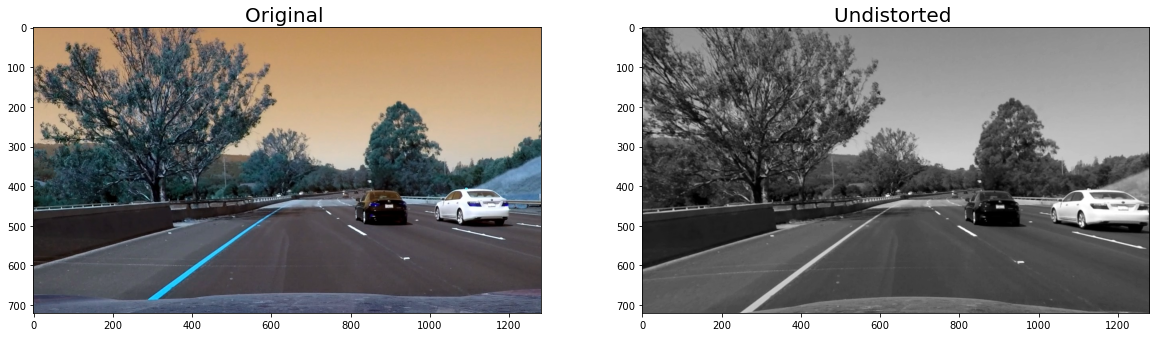

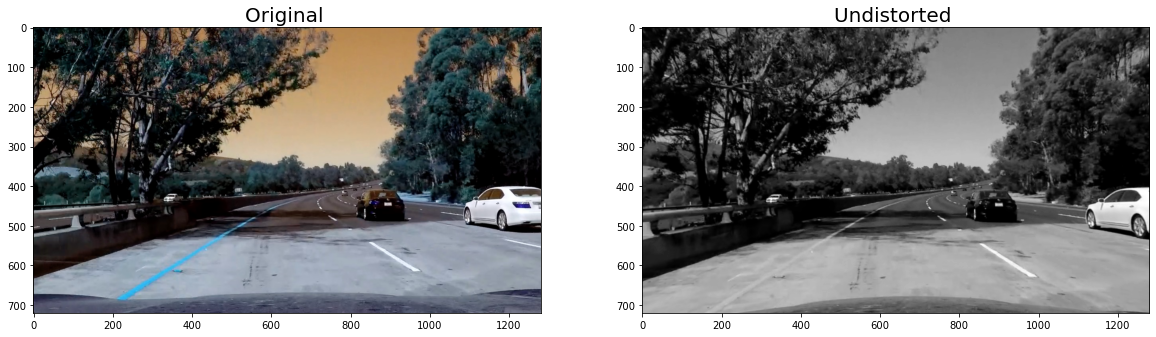

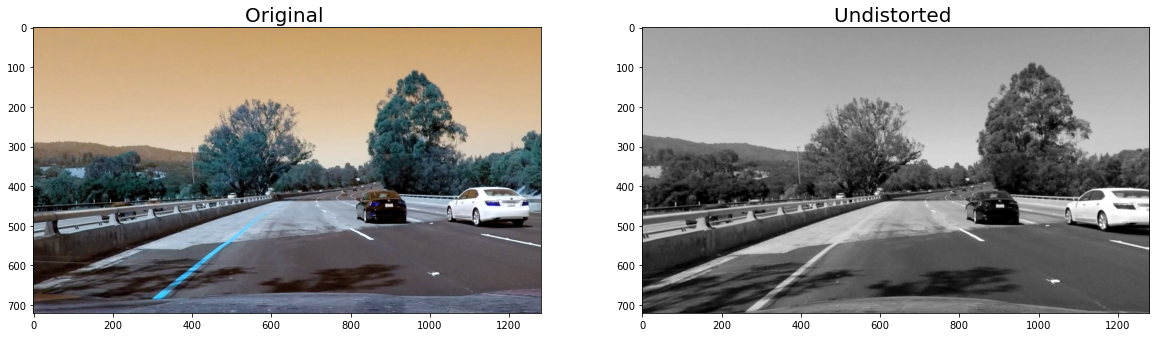

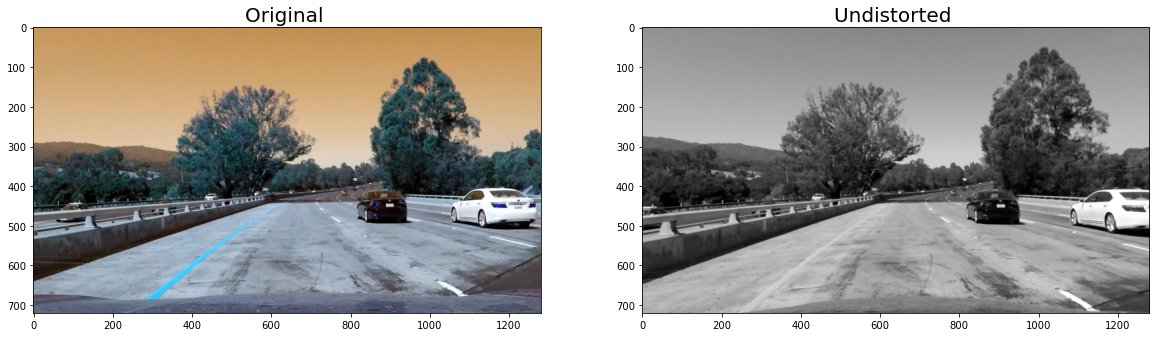

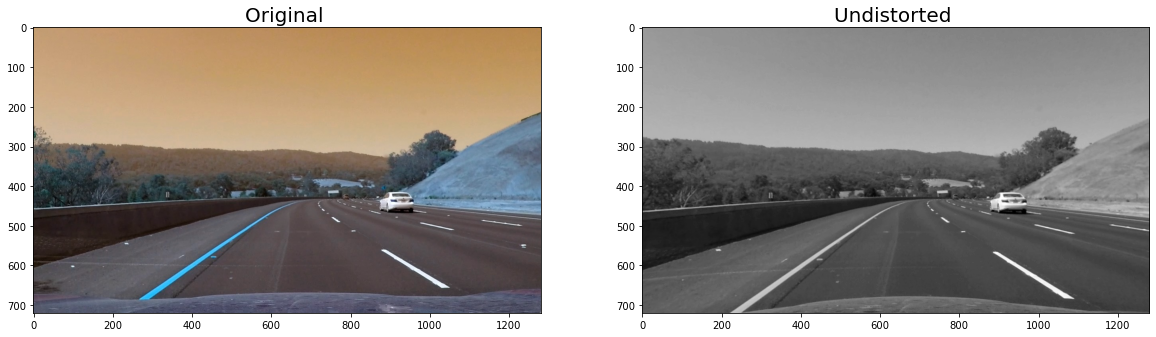

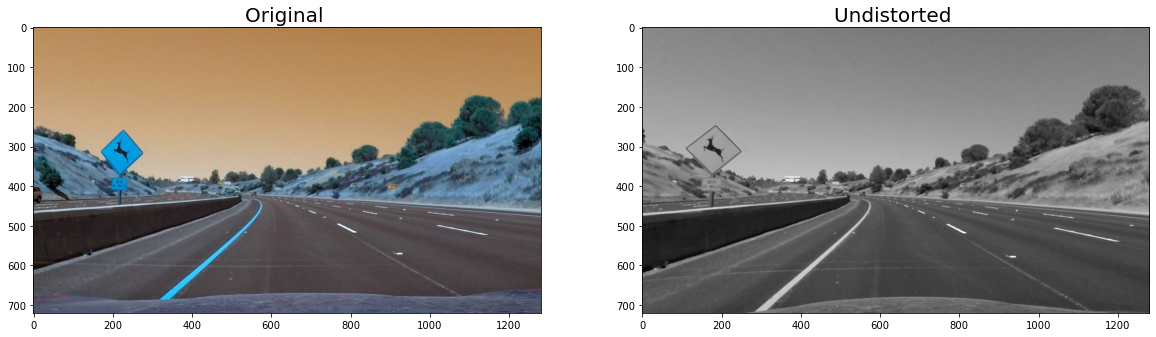

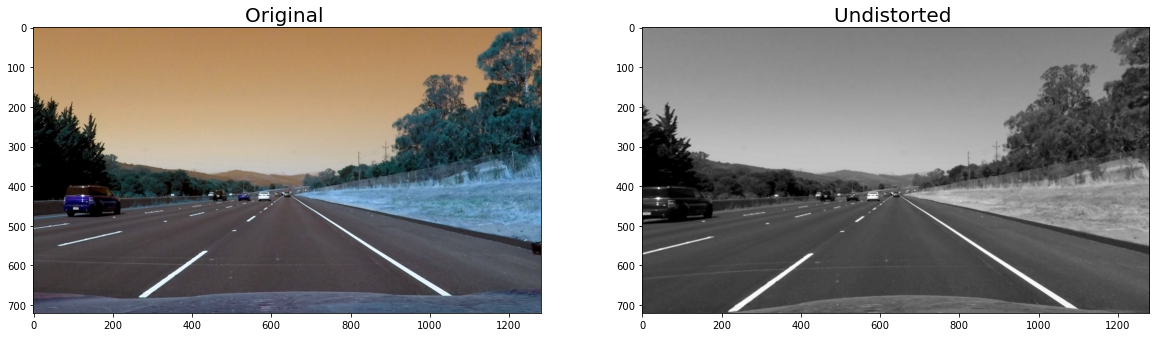

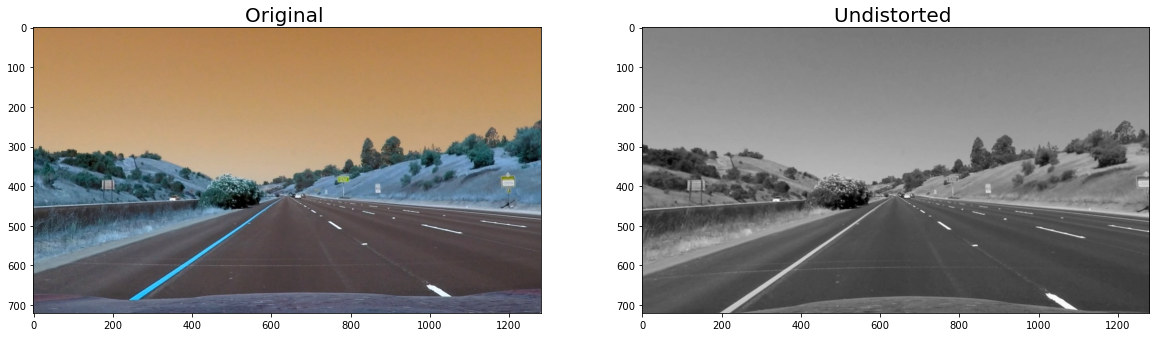

In [15]:
for i, fname in enumerate(images[:]):

    # Convert to gray
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Get matrix and distortion coefficients for camera
    undist, mtx, dist = cal_undistort(gray, objpoints, imgpoints)

    # Undistort the image
    undistorted_img = cv2.undistort(undist, mtx, dist, None, mtx) 
    
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
    ax1.imshow(img)
    ax1.set_title('Original ', fontsize=20)
    ax2.imshow(undistorted_img, cmap = 'gray')
    ax2.set_title('Undistorted ', fontsize=20)
    
    cv2.imwrite('./output_images/undistort_{:02d}.jpg' .format(i), undistorted_img)

## 3. Gradient and Colour threshold transformations

In [ ]:
# Transforms based on direction of gradient and applied thresholds
def abs_sobel_threshold(img, orient='x', sobel_kernel=3, sob_thresh=(0, 255)):

    thresh_min = sob_thresh[0]
    thresh_max = sob_thresh[1]
    
    # 1) Convert to grayscale
    # gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    # 2) Take the derivative in x or y given orient = 'x' or 'y'
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1))
    
    # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    
    # 5) Create a mask of 1's where the scaled gradient magnitude 
    # is > thresh_min and < thresh_max  
    sbinary = np.zeros_like(scaled_sobel)
    sbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
    
    grad_binary = sbinary
    
    return grad_binary

In [ ]:
# Transforms based on magnitude of gradient and applied thresholds
def mag_threshold(img, sobel_kernel=3, mag_thresh=(0, 255)):
    
    thresh_min = mag_thresh[0]
    thresh_max = mag_thresh[1]
    
    # 1) Convert to grayscale
    # gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1)
    
    # 3) Calculate the magnitude 
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    abs_sobelxy = np.sqrt(np.square(abs_sobelx) + np.square(abs_sobely))
    
    # 4) Scale to 8-bit (0 - 255) and convert to type = np.uint8
    scaled_sobel = np.uint8(255*abs_sobelxy/np.max(abs_sobelxy))
    
    # 5) Create a binary mask where mag thresholds are met
    sbinary = np.zeros_like(scaled_sobel)
    sbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
    
    mag_binary = sbinary
    
    return mag_binary

In [ ]:
# Transforms based on direction of gradient and applied thresholds
def dir_threshold(img, sobel_kernel=3, dir_thresh=(0, np.pi/2)):
    
    thresh_min = dir_thresh[0]
    thresh_max = dir_thresh[1]
    
    # 1) Apply the following steps to img
    # gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    
    # 3) Calculate the magnitude 
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    
    # 4) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient 
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    
    # 5) Create a binary mask where direction thresholds are met
    sbinary = np.zeros_like(absgraddir)
    sbinary[(absgraddir >= thresh_min) & (absgraddir <= thresh_max)] = 1
    
    dir_binary = sbinary
    
    return dir_binary

In [ ]:
# Transforms based on color of lines using HLS colorspace
def color_threshold(img, color_thresh=(0,255)):
    
    thresh_min = color_thresh[0]
    thresh_max = color_thresh[1]
    
    # 1) Convert to HLS color space
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    H = hls[:,:,0]
    L = hls[:,:,1]
    S = hls[:,:,2]
    # 2) Apply a threshold to the S channel
    binary = np.zeros_like(S)
    binary[(S > thresh_min) & (S <= thresh_max)] = 1
    # 3) Return a binary image of threshold result
    
    color_binary = binary
    
    return color_binary

In [ ]:
# Combine multiple gradient transformations 
def combined_gradient(img, s_thresh, x_thresh):
    
    ksize = 3 
    
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    color_binary = color_threshold(undist)
     
    # Grayscale image
    # gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # Apply each of the thresholding functions
    gradx = abs_sobel_threshold(color_binary, orient='x', sobel_kernel=ksize, sob_thresh=x_thresh)
    grady = abs_sobel_threshold(color_binary, orient='y', sobel_kernel=ksize, sob_thresh=x_thresh)
    mag_binary = mag_threshold(color_binary, sobel_kernel=ksize, mag_thresh=s_thresh)
    dir_binary = dir_threshold(color_binary, sobel_kernel=ksize, dir_thresh=(1., np.pi/2))

    combined = np.zeros_like(dir_binary)
    combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1

    img = combined.copy()
    combined_binary = cv2.convertScaleAbs(img, alpha=(255.0))
    
    return combined_binary  

In [ ]:
# Test on single image

# Read in an image
img = mpimg.imread('test_images/test6.jpg')

# Get matrix and distortion coefficients for camera
undist, mtx, dist = cal_undistort(gray, objpoints, imgpoints)

# Undistort the image
undistorted_img = cv2.undistort(img, mtx, dist, None, mtx) 

# Threshold on color channel
s_thresh = (170,255)
# Threshold on X gradient
x_thresh = (20,100)

combined_img = combined_gradient(undistorted_img, s_thresh, x_thresh)

# Plotting thresholded images
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,10))
ax1.set_title('Original test6.jpg')
ax1.imshow(img)
ax2.set_title('Gradient transforms')
ax2.imshow(combined_img)
ax3.set_title('Gradient and S-channel transforms')
ax3.imshow(combined_img, cmap='gray')


In [ ]:
# Process all images in test directory
images = glob.glob('test_images/*.jpg')

for i, fname in enumerate(images):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
   
    undist, mtx, dist = cal_undistort(gray, objpoints, imgpoints)
    
    # Undistort the image
    undistorted_img = cv2.undistort(img, mtx, dist, None, mtx) 
    
    # Threshold on color channel
    s_thresh = (170,255)
    # Threshold on X gradient
    x_thresh = (20,100)
    
    combined_img = combined_gradient(undistorted_img, s_thresh, x_thresh)
    
    #mpimg.imsave("output_images/undistort_"+fname[:-4]+".jpg", combined_img)
    cv2.imwrite('output_images/undistort_{:02d}.jpg'.format(i), combined_img)
    
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
    ax1.imshow(img)
    ax1.set_title('Original ' +fname, fontsize=20)
    ax2.imshow(combined_img, cmap = 'gray')
    ax2.set_title('Undistort + Gradient + S-channel transforms', fontsize=20)
    

## 4. Perspective transformation

In [ ]:
images = glob.glob('test_images/*.jpg')
print(images)

# Manually set the source area
fname = images[0]
img = plt.imread(fname).copy()
undist = cv2.undistort(img, mtx, dist, None, mtx)

color = [255,0,0]
width = 8

pos1 = (600, 450)  
pos2 = (720, 450) 
pos3 = (1200, 720)
pos4 = (200, 720)

cv2.line(undist, pos1, pos2, color, width)
cv2.line(undist, pos2, pos3, color, width)
cv2.line(undist, pos3, pos4, color, width)
cv2.line(undist, pos4, pos1, color, width)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original ' +fname, fontsize=20)
ax2.imshow(undist, cmap = 'gray')
ax2.set_title('Undistort with mask area', fontsize=20)

In [ ]:
def perspective(img):
    
    color = [255, 0, 0]
    width = 4

    cv2.line(img, pos1, pos2, color, width)
    cv2.line(img, pos2, pos3, color, width)
    cv2.line(img, pos3, pos4, color, width)
    cv2.line(img, pos4, pos1, color, width)
    
    src = np.float32( 
    [[pos1[0], pos1[1]],
     [pos2[0], pos2[1]],
     [pos3[0], pos3[1]],
     [pos4[0], pos4[1]],
    ])

    h, w = img.shape[:2]
    print(h, w)
    
    offset = 200
    dst = np.float32([[offset, 0],
                  [w - offset, 0], 
                  [w - offset, h], 
                  [offset,     h]])
    
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)

    warped = cv2.warpPerspective(img, M, (w,h), flags=cv2.INTER_LINEAR)
    warped = cv2.cvtColor(warped, cv2.COLOR_BGR2RGB)

    
    return warped, M, Minv

In [ ]:
warped, M, Minv = perspective(img)

In [ ]:

images = glob.glob('./output_images/undistort_*.jpg')

print(images)
for i, fname in enumerate(images):
    img = cv2.imread(fname, 0)
    #img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img_size = img.shape

    warped = cv2.warpPerspective(img, M, (img_size[1], img_size[0]))
    
    cv2.imwrite('output_images/warped_{:02d}.jpg'.format(i), warped)
    
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
    ax1.imshow(img, cmap ='gray')
    ax1.set_title('Undistorted ' +fname, fontsize=20)
    ax2.imshow(warped, cmap = 'gray')
    ax2.set_title('Warped ', fontsize=20)

## 5. Find lane lines

In [ ]:
# Histogram Peaks
# Load our image
# `mpimg.imread` will load .jpg as 0-255, so normalize back to 0-1
img = mpimg.imread('output_images/warped_02.jpg')

def hist(img):
    # TO-DO: Grab only the bottom half of the image
    # Lane lines are likely to be mostly vertical nearest to the car
    bottom_half = img[img.shape[0]//2:,:]

    # TO-DO: Sum across image pixels vertically - make sure to set `axis`
    # i.e. the highest areas of vertical lines should be larger values
    histogram =  np.sum(bottom_half, axis=0)
    
    
    return histogram

# Create histogram of image binary activations
histogram = hist(img)

# Visualize the resulting histogram
plt.plot(histogram)

In [ ]:
# Sliding Window
# Load our image
#binary_warped = mpimg.imread('./output_images/warped_02.jpg')
#binary_warped = mpimg.imread('./examples/warped_example.jpg')


images = glob.glob('output_images/warped_*.jpg')


def find_lane_pixels(binary_warped, nwindows=9, margin=100, minpix=50):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 2) 
        
        # Identify the nonzero pixels in x and y within the window #
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img


def fit_polynomial(binary_warped):
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)

    # Fit a second order polynomial to each using `np.polyfit`
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]

    # Plots the left and right polynomials on the lane lines
    #plt.plot(left_fitx, ploty, color='yellow')
    #plt.plot(right_fitx, ploty, color='yellow')

    return out_img, left_fit, right_fit, ploty

In [ ]:

fits = []

#print(images)
for i, fname in enumerate(images):
    
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    out_img, left_fit, right_fit, ploty = fit_polynomial(gray)
    
    fits.append([left_fit, right_fit])
    
    cv2.imwrite('output_images/warped+lanes_{:02d}.jpg'.format(i), out_img)
    
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
    ax1.imshow(img, cmap='gray')
    ax1.set_title('Warped ' +fname, fontsize=20)
    ax2.imshow(out_img)
    ax2.set_title('With lane lines ', fontsize=20)

## 6. Determine lane curvature

In [ ]:
# Measure curvature
# binary_warped = mpimg.imread('./output_images/warped_02.jpg')

print(locale.getdefaultlocale())

def measure_curvature_real():
    '''
    Calculates the curvature of polynomial functions in meters.
    '''
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    # Make sure to feed in your real data instead in your project!
    out_img, left_fit_cr, right_fit_cr, ploty = fit_polynomial(binary_warped)
    
    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    
    # Calculation of R_curve (radius of curvature)
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
    # Calculate vehicle bias
    left_point = left_fit_cr[0] * img.shape[0]**2 +  left_fit_cr[1] * img.shape[0] + left_fit_cr[2]
    right_point = right_fit_cr[0] * img.shape[0]**2 +  right_fit_cr[1] * img.shape[0] + right_fit_cr[2]

    line_center = (left_point + right_point) // 2  
    vehicle_posi = img.shape[1] // 2 
    
    vehicle_bias = (line_center - vehicle_posi) * xm_per_pix
    
    return left_curverad, right_curverad, vehicle_bias

images = glob.glob('output_images/warped_*.jpg')
for i, fname in enumerate(images):
    img = cv2.imread(fname)
    binary_warped = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Calculate the radius of curvature in meters for both lane lines
    left_curverad, right_curverad, vehicle_bias = measure_curvature_real()
    
    # Print curvature
    print(fname)
    print('Left: ',locale.format_string('%.2f',left_curverad, True), 'm', '  Right: ',locale.format_string('%.2f',right_curverad, True),'m')
    print("Vehicle Bias: ", locale.format_string('%.4f',vehicle_bias, True),"\n")
    

## 7. Overlay on road

In [ ]:
images = glob.glob('./test_images/*.jpg')
print(images)

def overlay(img, left_fit, right_fit):
    
    warp = np.zeros_like(img).astype(np.uint8)
    
    y = np.linspace(0, img.shape[0]-1, img.shape[0])
    x_left = left_fit[0] * y**2 + left_fit[1] * y + left_fit[2]
    x_right = right_fit[0] * y**2 + right_fit[1] * y + right_fit[2]
    
    x_left_pts = np.array([np.transpose(np.vstack([x_left, y]))])
    x_right_pts = np.array([np.flipud(np.transpose(np.vstack([x_right, y])))])
    
    pts = np.hstack((x_left_pts, x_right_pts))
    cv2.fillPoly(warp, np.int_([pts]), (0,255, 0))
    
    warp = cv2.warpPerspective(warp, Minv, (img.shape[1], img.shape[0])) 
    
    integ = cv2.addWeighted(img, 1, warp, 0.3, 0)
    
    left_curverad, right_curverad, vehicle_bias = measure_curvature_real()
    font = cv2.FONT_HERSHEY_DUPLEX
    color = (255, 255, 255)
    
    size=2
    cv2.putText(integ, 'Left lane curvature: {:.0f} m'.format(left_curverad), (20, 50), font, size, color, 2)
    cv2.putText(integ, 'Right lane curvature: {:.0f} m'.format(right_curverad), (20, 110), font, size, color, 2)
    cv2.putText(integ, 'Vehicle posi {:.2f}m'.format(vehicle_bias), (20, 170), font, size, color, 2)
    
    
    return integ
    


In [ ]:
images = glob.glob('./test_images/*.jpg')
for i, fname in enumerate(images):
    
    img = cv2.imread(fname)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    left_fit, right_fit = fits[i]
    
    img = overlay(img, left_fit, right_fit)
    
    cv2.imwrite('output_images/overlay_{:02d}.jpg'.format(i), img)
    
    plt.imshow(img)

## Pipeline 

In [ ]:
left_fit_prev = None
right_fit_prev = None
present_ratio = 0.5

# Threshold on color channel
s_thresh = (170,255)
# Threshold on X gradient
x_thresh = (20,100)

def pipeline(img, M):
    
    global left_fit_prev
    global right_fit_prev
    
    img_orig = img.copy()
    img = combined_gradient(img, s_thresh, x_thresh)
            
    img = cv2.warpPerspective(img, M, (img_size[1], img_size[0]))
    
    try:
        img, left_fit_tmp, right_fit_tmp, ploty = fit_polynomial(img)
        
        left_fit = left_fit_tmp
        right_fit = right_fit_tmp
        
        #print(left_fit)
          
        left_fit_prev = left_fit_tmp
        right_fit_prev = right_fit_tmp
        
        #print(left_fit, right_fit)
                     
    except Exception as e: 
        #print(e)
        left_fit = left_fit_prev
        right_fit = right_fit_prev
  
    integ = overlay(img_orig, left_fit, right_fit)
       
    return integ

In [ ]:
images = glob.glob('test_images/*.jpg')
fname = images[5]

img = plt.imread(fname).copy()

plt.figure()
plt.imshow(img)

img = pipeline(img, M)

plt.figure()
plt.imshow(img)